In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.optimizers import Adam


# Load and Prepare Data

In [8]:
df = pd.read_csv("product_grade_rating.csv")

# Simulate interaction data
np.random.seed(42)
users = [f"U{i:03d}" for i in range(100)]
interactions = pd.DataFrame({
    "user_id": np.random.choice(users, size=3000),
    "product_id": np.random.choice(df["product_id"], size=3000),
    "rating": np.random.randint(1, 6, size=3000)
})

# Content-Based Filtering (TF-IDF)

In [9]:
df["tag"] = df["brand"].astype(str) + " " + df["grade"].astype(str)

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df["tag"])
cosine_sim = cosine_similarity(tfidf_matrix)

def content_recommend(product_id, top_n=5):
    if product_id not in df["product_id"].values:
        return []
    idx = df[df["product_id"] == product_id].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    return df.iloc[[i[0] for i in sim_scores]]["product_id"].tolist()


# Encode User and Item IDs

In [10]:
user_enc = LabelEncoder()
item_enc = LabelEncoder()

interactions["user_enc"] = user_enc.fit_transform(interactions["user_id"])
interactions["item_enc"] = item_enc.fit_transform(interactions["product_id"])

n_users = interactions["user_enc"].nunique()
n_items = interactions["item_enc"].nunique()

# Deep Learning Collaborative Filtering


In [11]:
user_input = Input(shape=(1,), name="user_input")
item_input = Input(shape=(1,), name="item_input")

user_vec = Embedding(n_users, 50)(user_input)
user_vec = Flatten()(user_vec)

item_vec = Embedding(n_items, 50)(item_input)
item_vec = Flatten()(item_vec)

# Dot product + interaction
dot = Dot(axes=1)([user_vec, item_vec])
concat = Concatenate()([dot, user_vec, item_vec])
dense = Dense(64, activation='relu')(concat)
output = Dense(1)(dense)

model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer=Adam(0.001), loss='mse')

model.fit(
    x=[interactions["user_enc"], interactions["item_enc"]],
    y=interactions["rating"],
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 9.6402
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9577
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6452
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5122
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4519


# Deep Recommendation

In [12]:

def deep_recommend(user_id, top_n=5):
    if user_id not in user_enc.classes_:
        return []
    user_idx = user_enc.transform([user_id])[0]
    all_items = np.arange(n_items)
    predictions = model.predict([np.full(n_items, user_idx), all_items], verbose=0).flatten()
    top_items = np.argsort(predictions)[-top_n:][::-1]
    return item_enc.inverse_transform(top_items)


# Hybrid Function

In [13]:
def hybrid_recommend(user_id, product_id=None, top_n=5):
    cbf = content_recommend(product_id, top_n=top_n) if product_id else []
    dl = deep_recommend(user_id, top_n=top_n)
    merged = list(dict.fromkeys(cbf + list(dl)))  # Remove duplicates, preserve order
    return merged[:top_n]

In [15]:
if __name__ == "__main__":
    uid = "U001"
    pid = df["product_id"].iloc[0]
    print(f"Hybrid recommendations for user {uid} and product {pid}:")
    print(hybrid_recommend(uid, pid))

Hybrid recommendations for user U001 and product P0000:
['P0012', 'P0032', 'P0077', 'P0089', 'P0145']


# Visualization & Analysis

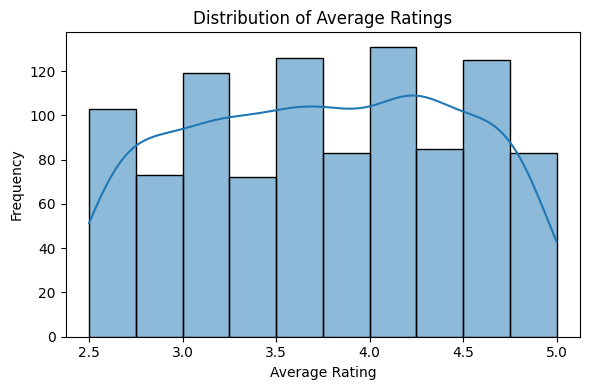

In [16]:
plt.figure(figsize=(6, 4))
sns.histplot(df["avg_rating"], bins=10, kde=True)
plt.title("Distribution of Average Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

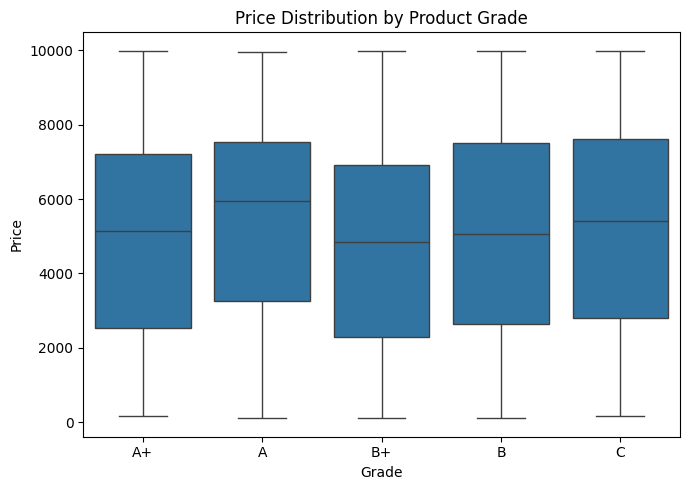

In [19]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x="grade", y="price")
plt.title("Price Distribution by Product Grade")
plt.xlabel("Grade")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

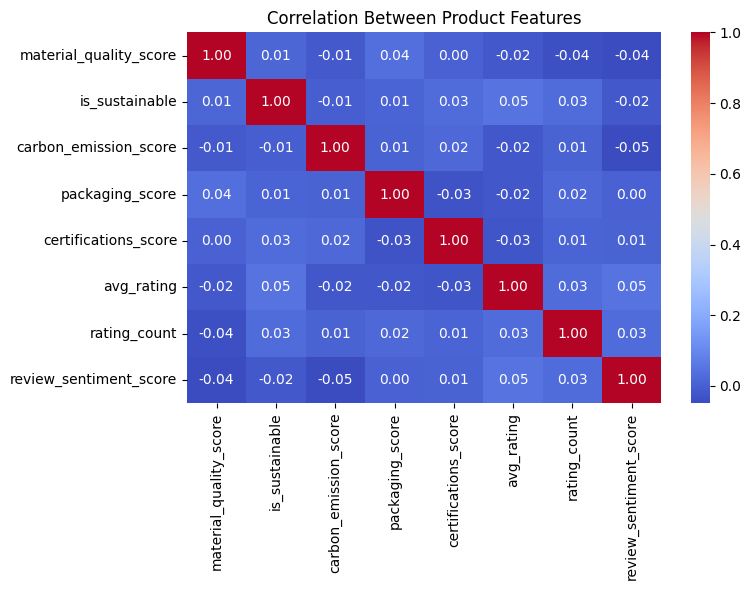

In [20]:
numeric_features = df.select_dtypes(include=[float, int]).drop(columns=["price"], errors="ignore")
corr = numeric_features.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Product Features")
plt.tight_layout()
plt.show()